Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or elise or stephan, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = "Arend van Dormalen and Oscar Ligthart"

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [3]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

In [4]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [5]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [6]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)

    while True:
        # initialize new value function
        V_new = np.zeros_like(V)

        # loop through all states and actions
        for state in range(len(V)):
            for action in range(env.nA):
                # get reward and next state
                reward = env.P[state][action][0][2]
                next_state = env.P[state][action][0][1]
                
                # for each state, sum over all actions                
                V_new[state] += policy[state][action] * (reward + discount_factor * V[next_state])
          
        # exit if difference between V_new and V is lower than parameter theta
        if np.allclose(V_new, V, theta):
            V = V_new
            break
        
        # update V
        V = V_new

    return np.array(V)

In [7]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V


array([  0.        , -13.99771852, -19.99661926, -21.99621676,
       -13.99771852, -17.99702177, -19.99664188, -19.99661926,
       -19.99661926, -19.99664188, -17.99702177, -13.99771852,
       -21.99621676, -19.99661926, -13.99771852,   0.        ])

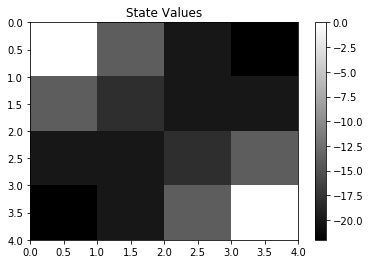

In [8]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top
    plt.title('State Values')

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [9]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [10]:
def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:        
        # get converged state values
        V = policy_eval(policy, env, discount_factor)  
        
        # initialize new policy
        new_policy = np.zeros_like(policy)
        
        # for every state
        for state in range(env.nS):
            
            # get max action (calculate q-values for all actions and pick highest value)
            q_list = []
            for action in range(env.nA):
                # get reward and next state
                reward = env.P[state][action][0][2]
                next_state = env.P[state][action][0][1]
                
                # calculate q-values and keep track of them for all actions
                q = (reward + discount_factor * V[next_state])
                q_list.append(q)
                
            # choose best action
            best_action = np.argmax(q_list)
            
            # update policy in a deterministic way
            new_policy[state][best_action] = 1
        
        # check if new policy is the same as the previous policy
        if np.array_equal(new_policy, policy):
            break
            
        policy = new_policy
    
    return policy, V


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



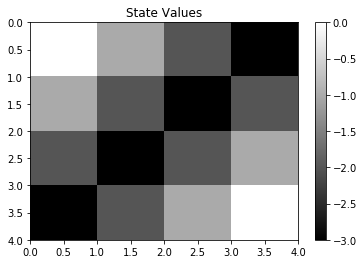

In [11]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [12]:
import time
a = time.time()
policy, v = policy_improvement(env)
print(time.time() - a)

0.025420188903808594


In [13]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [14]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    
    delta = 1
    while delta > theta:
        policy = np.zeros([env.nS, env.nA])
        delta = 0 
        for state in range(env.nS):
            # save current state value
            v = V[state]

            # get max action (calculate q-values for all actions and pick highest value)
            q_list = []
            for action in range(env.nA):
                # get reward and next state
                reward = env.P[state][action][0][2]
                next_state = env.P[state][action][0][1]
                
                # calculate q-values and keep track of them for all actions
                q = (reward + discount_factor * V[next_state])
                q_list.append(q)
                
            # choose best action
            best_action = np.argmax(q_list)
            
            # get reward and next state based on best action
            reward = env.P[state][best_action][0][2]
            next_state = env.P[state][best_action][0][1]

            # update state value and deterministic policy
            V[state] = (reward + discount_factor * V[next_state])
            policy[state][best_action] = 1
            
            # keep track of maximum state difference
            delta = max(delta, abs(v - V[state]))
    
    return policy, V

In [15]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [16]:
import time
a = time.time()
policy, v = value_iteration(env)
print(time.time() - a)

0.0008602142333984375


What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

**OUR ANSWER**

The difference between value iteration and policy iteration lies in its iteration steps. In policy iteration, we update the state-values until convergence before updating the policy. In value iteration, we update the state-values once before updating the policy.

This makes value iteration more efficient in theory. In our gridworld environment, we find that value iteration is about 7 times faster. 
However, it should be noted that this efficiency increase does not hold for more complicated environments. In these environments, a single update of the state-values might not be sufficient for updating the policy. This means that the number of iterations in value iteration will be much larger than for policy iteration in this case.

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

**OUR ANSWER**

Dynamic Programming explores all state-action transitions before going deeper into further states (breadth-first). Monte Carlo is a depth-first algorithm, meaning it samples state-action transitions per state until it reaches a terminal state.

You can only use Dynamic Programming if all state-action transitions are known, while Monte Carlo does not have this constraint due to the fact that it can estimate these transitions.


For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [3]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [4]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [5]:
# We can also look at the documentation/implementation of a method
?env.step

In [6]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [7]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """

    # check whether player score is >= 20
    if observation[0] >= 20:
        # stick
        a = 0
    else:
        # hit
        a = 1
    
    return a


In [8]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(19, 10, False)
((24, 10, False), -1, True, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [9]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i in tqdm(range(num_episodes)):
                        
        # generate an episode
        s = env.reset()
        episode = []
        done = False
        while not done:
            a = policy(s)
            trans = env.step(a) #next_state, reward, done, _
    
            # keep track of what happens during this step in the  episode
            ep_step = (s, a, trans[1])
            episode.append(ep_step)
           
            # update variables
            s = trans[0]
            done = trans[2]
       
        # create list of states
        states = [step[0] for step in episode]

        # initialize G
        G = 0
        
        # loop through reversed episode
        for j, step in enumerate(reversed(episode)): # step has the form: (S_t, A_t, R_t+1)
            # get current state
            state = step[0]
            reward = step[2]
            
            # update G
            G = discount_factor * G + reward             
            
            # check if state has not been seen before
            t = len(episode) - j             
            if step[0] not in states[:t-1]:  
                
                returns_sum[state] += G
                returns_count[state] += 1
                
                # update value function
                V[state] = returns_sum[state]/ returns_count[state]
    
    return V

In [24]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
from pprint import pprint
pprint(V)

100%|██████████| 1000/1000 [00:00<00:00, 17094.14it/s]

defaultdict(<class 'float'>,
            {(12, 1, False): -0.5833333333333334,
             (12, 2, False): -0.6923076923076923,
             (12, 3, False): -0.375,
             (12, 3, True): -1.0,
             (12, 4, False): 0.2222222222222222,
             (12, 5, False): -0.3,
             (12, 6, False): -0.25,
             (12, 7, False): -0.8,
             (12, 8, False): -1.0,
             (12, 8, True): -1.0,
             (12, 9, False): -0.8,
             (12, 9, True): 1.0,
             (12, 10, False): -0.5151515151515151,
             (12, 10, True): -1.0,
             (13, 1, False): -0.3333333333333333,
             (13, 2, False): -0.45454545454545453,
             (13, 2, True): -1.0,
             (13, 3, False): -0.8333333333333334,
             (13, 3, True): -1.0,
             (13, 4, False): -0.45454545454545453,
             (13, 5, False): -0.6923076923076923,
             (13, 5, True): 0.0,
             (13, 6, False): -0.5555555555555556,
             (13, 7

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [8]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|██████████| 500000/500000 [00:20<00:00, 23858.52it/s]

CPU times: user 21.4 s, sys: 6.37 ms, total: 21.4 s
Wall time: 21.4 s


In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

# get all possible dealer sum and player sum values
x = []
y = []
for state in V_500k.keys():
    x.append(state[0])
    y.append(state[1])


# create meshgrid of all possible dealer sum and player sum combination states
x_range = np.arange(min(x), max(x)+1)
y_range = np.arange(min(y), max(y)+1)
player_sum, dealer_sum = np.meshgrid(x_range, y_range)

print(player_sum, dealer_sum)

# get all action values for usable and non-usable aces
ace_value = np.zeros_like(player_sum,dtype=np.float64)
no_ace_value = np.zeros_like(player_sum,dtype=np.float64)

# loop through possible states and save action value
for i,x in enumerate(x_range):
    for j,y in enumerate(y_range):        
        st_ace = (x,y,True)
        ace_value[j,i] = V_500k[st_ace]
        
        st_no_ace = (x,y,False)        
        no_ace_value[j,i] = V_500k[st_no_ace]

# plot ace action values
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(dealer_sum, player_sum, ace_value, cmap=cm.coolwarm)
plt.xlabel('Dealer showing')
plt.ylabel('Player sum')
plt.title('Useable ace: 3D surface plot')

# plot ace action values in a heatmap
fig = plt.figure()
im = plt.pcolor(y_range, x_range, ace_value.T, cmap=cm.coolwarm, vmin=-1, vmax=1)
fig.colorbar(im)
plt.title('Useable ace: heatmap')
plt.ylabel('Player sum')
plt.xlabel('Dealer showing')

# plot no ace action values
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(dealer_sum, player_sum, no_ace_value, cmap=cm.coolwarm)
plt.xlabel('Dealer showing')
plt.ylabel('Player sum')
plt.title('No useable ace: 3D surface plot')

# plot no ace action values in a heatmap
fig = plt.figure()
im = plt.pcolor(y_range, x_range, no_ace_value.T, cmap=cm.coolwarm, vmin=-1, vmax=1)
fig.colorbar(im)
plt.title('No useable ace: heatmap')
plt.ylabel('Player sum')
plt.xlabel('Dealer showing')
plt.show()

NameError: name 'V_500k' is not defined

Unfortunately, we found that the movable 3d plot using " %matplotlib notebook " would sometimes produce a white page as output.

## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy.

In [11]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # initiate policy with epsilon probability over all random choices 
        #(can the random action also be the chosen action?)
        A = np.array(([epsilon/nA for i in range(nA)]), dtype=float) 
        best_action = np.argmax(Q[observation])
        A[best_action] += 1 - epsilon
        return A
    return policy_fn

In [12]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i in tqdm(range(num_episodes)):

        # generate an episode
        s = env.reset()
        episode = []
        done = False
        while not done:
            # get action probabilities
            A = policy(s)

            # choose action according to policy
            a = np.random.choice(range(len(A)), p=A)

            # perform action in environment
            trans = env.step(a) #next_state, reward, done, _

            # keep track of what happens during this step in the  episode
            ep_step = (s, a, trans[1])
            episode.append(ep_step)

            # update variables
            s = trans[0]
            done = trans[2]

        # create list of states
        state_actions = [(step[0], step[1]) for step in episode]
        
        G = 0
        # reverse loop through episode
        for j, step in enumerate(reversed(episode)): # step has the form: (S_t, A_t, R_t+1)
            # get current state, action and reward
            state = step[0]
            action = step[1]
            reward = step[2]
            
            # get current state action pair
            s_a = (step[0], step[1])
            
            # calculate G
            G = discount_factor * G + reward 
            
            # check if state action pair is not seen yet
            t = len(episode) - j            
            if s_a not in state_actions[:t-1]: 
                                
                returns_sum[state][action] += G
                returns_count[state][action] += 1
                
                # update Q value
                Q[state][action] = returns_sum[state][action]/ returns_count[state][action]
    
    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████| 10000/10000 [00:00<00:00, 10330.63it/s]


In [29]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [00:48<00:00, 10214.52it/s]

CPU times: user 49 s, sys: 27.3 ms, total: 49 s
Wall time: 49 s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

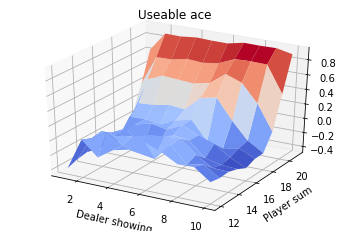

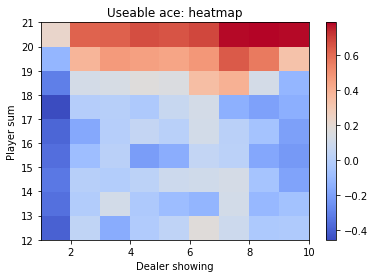

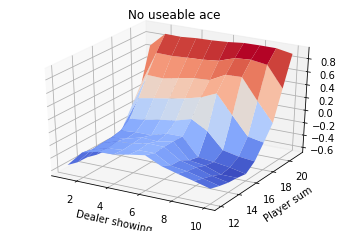

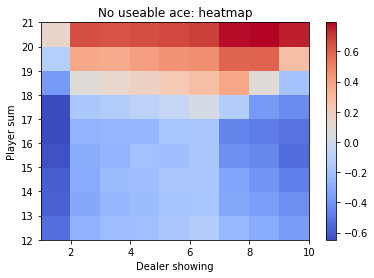

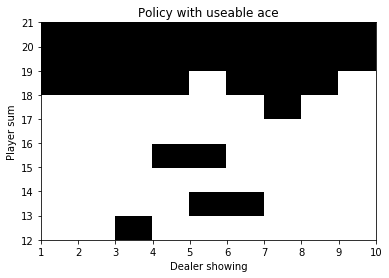

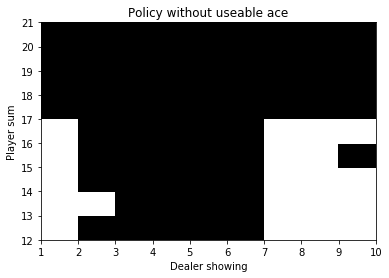

In [30]:
##### Plot value function #####

# get all possible dealer sum and player sum values
x = []
y = []
aces = []
for state in Q.keys():
    x.append(state[0])
    y.append(state[1])
    aces.append(state[2])

# create meshgrid of all possible dealer sum and player sum combination states
x_range = np.arange(min(x), max(x)+1)
y_range = np.arange(min(y), max(y)+1)
player_sum, dealer_sum = np.meshgrid(x_range, y_range)

# get all action values for usable and non-usable aces
ace_value = np.zeros_like(player_sum,dtype=np.float64)
no_ace_value = np.zeros_like(player_sum,dtype=np.float64)

# loop through possible states and save action value
for i,x in enumerate(x_range):
    for j,y in enumerate(y_range):        
        st_ace = (x,y,True)
        ace_value[j,i] = max(Q[st_ace])
        
        st_no_ace = (x,y,False)        
        no_ace_value[j,i] = max(Q[st_no_ace])

        
# Plot ace
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(dealer_sum, player_sum, ace_value, cmap=cm.coolwarm)
plt.xlabel('Dealer showing')
plt.ylabel('Player sum')
plt.title('Useable ace')

# plot ace action values in a heatmap
fig = plt.figure()
im = plt.pcolor(y_range, x_range, ace_value.T, cmap=cm.coolwarm)
fig.colorbar(im)
plt.title('Useable ace: heatmap')
plt.ylabel('Player sum')
plt.xlabel('Dealer showing')

# plot no ace action values
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(dealer_sum, player_sum, no_ace_value, cmap=cm.coolwarm)
plt.xlabel('Dealer showing')
plt.ylabel('Player sum')
plt.title('No useable ace')

# plot no ace action values in a heatmap
fig = plt.figure()
im = plt.pcolor(y_range, x_range, no_ace_value.T, cmap=cm.coolwarm)
fig.colorbar(im)
plt.title('No useable ace: heatmap')
plt.ylabel('Player sum')
plt.xlabel('Dealer showing')
plt.show()

##### Visualize greedy policy #####

for i,x in enumerate(x_range):
    for j,y in enumerate(y_range):        
        st_ace = (x,y,True)
        ace_value[j,i] = np.argmax(Q[st_ace])
        
        st_no_ace = (x,y,False)        
        no_ace_value[j,i] = np.argmax(Q[st_no_ace])

# show policy with useable ace
fig = plt.figure()
plt.pcolor(y_range, x_range, 1-ace_value.T, cmap=cm.Greys)
plt.title('Policy with useable ace')
plt.ylabel('Player sum')
plt.xlabel('Dealer showing')

# show policy without useable ace
fig = plt.figure()
plt.pcolor(y_range, x_range, 1-no_ace_value.T, cmap=cm.Greys)
plt.title('Policy without useable ace')
plt.ylabel('Player sum')
plt.xlabel('Dealer showing')

plt.show()

## 6. Temporal Difference (TD) learning (8 points)
Mention one advantage and one disadvantage of Monte Carlo methods. Mention an example where you would prefer to use TD learning.

**OUR ANSWER**

*Advantage*: They do not need a model of the environment, since they can learn optimal behaviour directly from interaction with the environment.

*Disadvantage*: In the case of long trajectories to the terminal state, Monte Carlo will be inefficient.

An example of when to use TD learning is when the environment is continous and the terminal state is not known or very far away. The reason for this is that TD learning uses bootstrapping and thus it can update before reaching the terminal state.

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. In other words: implement SARSA. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [31]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

In [32]:
WindyGridworldEnv??

100%|██████████| 1000/1000 [00:01<00:00, 858.73it/s]


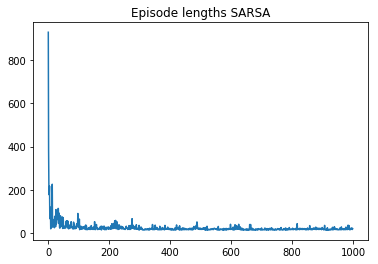

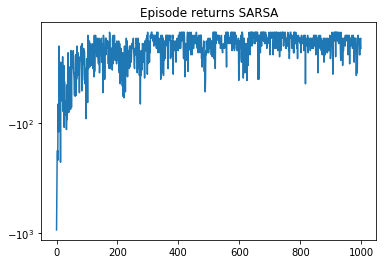

In [33]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # initialize S
        state = env.reset()
       
        # choose action according to policy
        A = policy(state)
        action = np.random.choice(range(env.action_space.n), p=A)
        
        # run episode until terminal state
        done = False
        while not done:   
                
            # take action, observe reward
            state_prime, reward, done, _ = env.step(action)
                
            # choose action according to policy
            A = policy(state_prime)
            action_prime = np.random.choice(range(env.action_space.n), p=A)
            
            # update Q-value
            delta = (discount_factor* Q[state_prime][action_prime]) - Q[state][action]
            Q[state][action] = Q[state][action] + alpha*(reward + delta)
            
            # update variables
            state = state_prime
            action = action_prime
            
            # keep track of episode length
            i += 1
            R += reward
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)

# We will help you with plotting this time
plt.figure()
plt.plot(episode_lengths_sarsa)
plt.title('Episode lengths SARSA')
plt.show()

plt.figure()
plt.plot(episode_returns_sarsa)
plt.yscale('symlog')
plt.title('Episode returns SARSA')
plt.show()

Since we might not be interested in falling off the cliff all the time, we can find another person to do this 'exploration' for us (in the name of science). Still, we would like to learn ourselfs from this persons policy, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

100%|██████████| 1000/1000 [00:01<00:00, 826.58it/s]


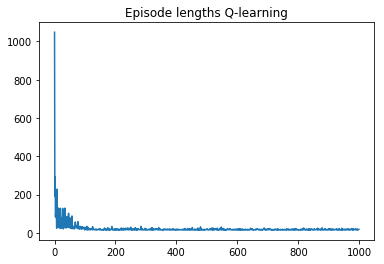

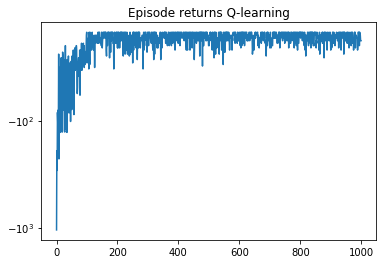

In [34]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # initialize S
        state = env.reset()
        
        # choose action according to policy
        A = policy(state)
        action = np.random.choice(range(env.action_space.n), p=A)
        
        # loop for each step in episode
        done = False
        while not done:  
               
            # take action, observe reward
            state_prime, reward, done, _ = env.step(action)
            
            # choose action based on policy
            A = policy(state_prime)
            action_prime = np.random.choice(range(env.action_space.n), p=A)
            
            # update Q-value
            delta = (discount_factor* max(Q[state_prime])) - Q[state][action]
            Q[state][action] = Q[state][action] + alpha*(reward + delta)
            
            # update variables
            state = state_prime
            action = action_prime
            
            # keep track of episode length
            i += 1
            R += reward
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.figure()
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()

plt.figure()
plt.plot(episode_returns_q_learning)
plt.yscale('symlog')
plt.title('Episode returns Q-learning')
plt.show()


Now compare the episode returns while learning for Q-learning and Sarsa (maybe run some more iterations?), by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, you may want to zoom in on the y-axis and smooth the returns (e.g. plotting the $n$ episode average instead). Which algorithm achieves higher return during learning? How does this compare to Example 6.6 from the book? Try to explain your observations.

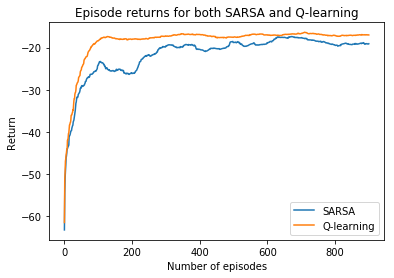

In [35]:
# create filter
n = 100
filt = [1/n for i in range(n)]

# convolve the lines 
avg_returns_sarsa = np.convolve(episode_returns_sarsa, filt, 'valid')
avg_returns_q_learning = np.convolve(episode_returns_q_learning, filt, 'valid')

# show the difference between SARSA and Q-learning
plt.figure()
plt.plot(avg_returns_sarsa, label='SARSA')
plt.plot(avg_returns_q_learning, label='Q-learning')

plt.legend()
plt.title('Episode returns for both SARSA and Q-learning')
plt.xlabel('Number of episodes')
plt.ylabel('Return')
plt.show()

**OUR ANSWER**

Q-learning achieves higher average return during learning. This is in contrast with example 6.6 from the book, where SARSA outperforms Q-learning. The reason for this is the cliff found in example 6.6. Q-learning will always update its policy according to the greedy action, meaning it will take the closest path towards the goal no matter the risk. The risk being a reward of -100 in example 6.6. SARSA will update its policy according to the $\epsilon$-greedy action, meaning it will take risk into account and look for a more "safer" path. This causes Q-learning to perform worse during training, since it has a high risk of falling of the cliff and receiving a reward of -100, while SARSA will not fall into the cliff during training due to the more "safer" path.

In this problem, there is no cliff, so there is no severe punishment for ignoring exploration in the policy. SARSA updates its policy based on exploration. Unlike in the previous example, there is no benefit in straying away from the one optimal path in this problem, causing SARSA to perform worse. Q-learning does not update based on exploration and therefore performs better.

After we have learned the policy, we do not care about exploration any more and we may switch to a deterministic (greedy) policy instead. If we evaluate this for both Sarsa and Q-learning (actually, for Q-learning the learned policy is already deterministic), which policy would you expect to perform better? Why?

**OUR ANSWER**

Q-learning will perform better. Since both the policy and the environment are deterministic, there will only be one optimal path. During training Q-learning learns the policy that traverses this optimal path only, while SARSA updates its policy on exploration (straying away from this optimal path) as well.

Please run the experiments to test your hypothesis (print or plot your results). How many runs do you need to evaluate the policy? Note: without learning, the order of the episodes is not relevant so a normal `plt.plot` may not be the most appropriate choice.

In [36]:
def eval_TD_learning(env, Q):
    # Function to evaluate a greedy policy

    # initialize S and R
    state = env.reset()
    R = 0

    # keep track of number of steps taken, policy might not get to ending 
    counter = 0

    # run episode until terminal state (set maximum amount of steps that can be taken)
    done = False
    while not done and counter < 500: 
        # choose action according to greedy policy
        action = np.argmax(Q[state])   

        # take action, observe reward
        state_prime, reward, done, _ = env.step(action)

        # update variables
        state = state_prime

        # keep track of total reward
        R += reward
        counter += 1

    return R

# hyperparameters
N = 10
episodes = 200
total_result_sarsa = []
total_result_q_learning = []

# train methods and evaluate policies N amount of times
for i in range(N):
    # get Q
    Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, episodes)
    Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, episodes)

    # evaluate policy
    result_sarsa = eval_TD_learning(env, Q_sarsa)
    result_q_learning = eval_TD_learning(env, Q_q_learning)
    
    total_result_sarsa.append(result_sarsa)
    total_result_q_learning.append(result_q_learning)

print('Final episode reward for 10 different policies learned by SARSA:')
print(total_result_sarsa)

print()

print('Final episode reward for 10 different policies learned by Q-learning:')
print(total_result_q_learning)



100%|██████████| 200/200 [00:00<00:00, 475.96it/s]

Final episode reward for 10 different policies learned by SARSA:
[-15.0, -15.0, -16.0, -500.0, -17.0, -500.0, -500.0, -17.0, -16.0, -15.0]

Final episode reward for 10 different policies learned by Q-learning:
[-15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0]


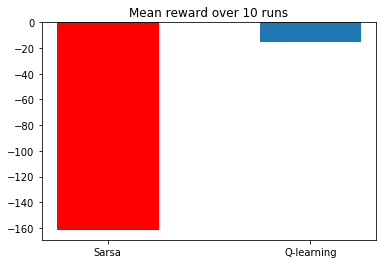

In [37]:
mean_sarsa = np.mean(total_result_sarsa)
mean_q_learning = np.mean(total_result_q_learning)

barlist=plt.bar(['Sarsa','Q-learning'], [mean_sarsa, mean_q_learning], width=0.5)
barlist[0].set_color('r')

plt.title('Mean reward over ' + str(N) +' runs')
plt.show()

**OUR ANSWER** 

Since both the environment and policy are now deterministic, you only need 1 run to evaluate the policy since it will always yield the same results. 

The reason for the big difference in performance between SARSA and Q-learning is caused by the fact that SARSA might get stuck in the WindyGridWorld by learning a policy that performs an action that is counteracted by the wind. This causes SARSA to constantly take the action that leads it back to its current state. We set the maximum amount of steps to 500 for the policy evaluation, otherwise it would just be stuck in an infinite loop. Q-learning is not susceptible to this problem, since the policy will not be updated based on (non-beneficial) explorative actions. 

In some runs the difference between the methods is less dramatic, due to the fact that SARSA then learns an explorative action that is not counteracted by the wind and can thus be accounted for during the run.

Q-learning just learns the optimal path in its policy, exploration has no effect on updating the policy as long as it is not beneficial. Therefore, it will always yield the shortest path using a greedy policy in the WindyGridWorld.
